In [1]:
# Install the libraries you need

! pip install lightgbm

In [2]:
! pip install shap

In [3]:
# Import all the libraries you'll be using

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as plt
from datetime import date
import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import boto3
import datetime
from sklearn.model_selection import train_test_split
import shap


%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/opt/anaconda3/envs/python-data3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Data Collection

In [4]:
# Load dataset provided from Kaggle
# We merge the the training and test dataset for now, as we'll run QA and transformations on all the data

df_train = pd.read_csv('job change of data scientists/aug_train.csv')
df_test = pd.read_csv('job change of data scientists/aug_test.csv')
df = pd.concat([df_train, df_test])

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
# Size of the data
df.shape

(21287, 14)

In [6]:
# Checkout the features
df.head()

,city,city_development_index,company_size,company_type,education_level,enrolled_university,enrollee_id,experience,gender,last_new_job,major_discipline,relevent_experience,target,training_hours
0,city_103,0.920,NaN,NaN,Graduate,no_enrollment,8949,>20,Male,1,STEM,Has relevent experience,1.0,36
1,city_40,0.776,50-99,Pvt Ltd,Graduate,no_enrollment,29725,15,Male,>4,STEM,No relevent experience,0.0,47
2,city_21,0.624,NaN,NaN,Graduate,Full time course,11561,5,NaN,never,STEM,No relevent experience,0.0,83
3,city_115,0.789,NaN,Pvt Ltd,Graduate,NaN,33241,<1,NaN,never,Business Degree,No relevent experience,1.0,52
4,city_162,0.767,50-99,Funded Startup,Masters,no_enrollment,666,>20,Male,4,STEM,Has relevent experience,0.0,8


## Data Exploration

In [7]:
df.shape

(21287, 14)

In [8]:
# Unique on enrollee id

df['enrollee_id'].nunique() == df.shape[0]

True

In [9]:
# Any person duplicates?

df['duplicated'] = df.drop(columns = ['enrollee_id']).duplicated()

In [10]:
df['duplicated'].value_counts()

False    21237
True        50
Name: duplicated, dtype: int64

In [11]:
df.drop(df[df['duplicated'] == True].index, inplace = True)
df.head(2)
print(f'New df size is {df.shape}')

New df size is (21235, 15)


In [12]:
# Descriptive stats

df.describe()

,city_development_index,enrollee_id,target,training_hours
count,21235.000000,21235.000000,19108.000000,21235.000000
mean,0.828312,16871.884624,0.249372,65.397174
std,0.123575,9610.508821,0.432661,60.114693
min,0.448000,1.000000,0.000000,1.000000
25%,0.739000,8558.500000,0.000000,23.000000
50%,0.903000,16958.000000,0.000000,47.000000
75%,0.920000,25158.500000,0.000000,88.000000
max,0.949000,33380.000000,1.000000,336.000000


In [13]:
# Check unique and null counts, does everything look as expected?

for col in df.columns:
    print(f' \n {col.upper()} contains {df[col].nunique()} unique values and {df[col].isnull().sum()} nulls')

 
 CITY contains 123 unique values and 0 nulls
 
 CITY_DEVELOPMENT_INDEX contains 93 unique values and 0 nulls
 
 COMPANY_SIZE contains 8 unique values and 6541 nulls
 
 COMPANY_TYPE contains 6 unique values and 6755 nulls
 
 EDUCATION_LEVEL contains 5 unique values and 512 nulls
 
 ENROLLED_UNIVERSITY contains 3 unique values and 417 nulls
 
 ENROLLEE_ID contains 21235 unique values and 0 nulls
 
 EXPERIENCE contains 22 unique values and 70 nulls
 
 GENDER contains 3 unique values and 5015 nulls
 
 LAST_NEW_JOB contains 6 unique values and 463 nulls
 
 MAJOR_DISCIPLINE contains 6 unique values and 3121 nulls
 
 RELEVENT_EXPERIENCE contains 2 unique values and 0 nulls
 
 TARGET contains 2 unique values and 2127 nulls
 
 TRAINING_HOURS contains 241 unique values and 0 nulls
 
 DUPLICATED contains 1 unique values and 0 nulls


In [14]:
# Drop unlabeled target rows

df.dropna(subset=['target'], how='all', inplace=True)

In [15]:
print(df.shape[0])
      
df['target'].value_counts()

19108


0.0    14343
1.0     4765
Name: target, dtype: int64

In [16]:
df['company_size'].value_counts()

50-99        3080
100-500      2560
10000+       2009
10/49        1470
1000-4999    1322
<10          1308
500-999       877
5000-9999     562
Name: company_size, dtype: int64

In [17]:
# Tidy up 10/49 to 10-49

df['company_size'] = df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)

In [18]:
df['company_size'].value_counts()

50-99        3080
100-500      2560
10000+       2009
10-49        1470
1000-4999    1322
<10          1308
500-999       877
5000-9999     562
Name: company_size, dtype: int64

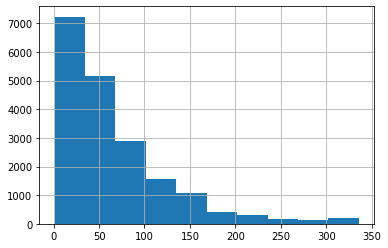

In [19]:
# Training hours distribution

df['training_hours'].hist()

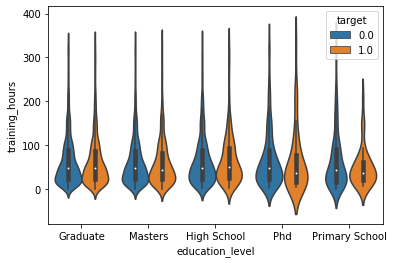

In [20]:
# Seaborn example

sns.violinplot(data=df, x="education_level", y="training_hours", hue="target", gridsize = 200)

## Feature Engineering

In [21]:
df.head()

,city,city_development_index,company_size,company_type,education_level,enrolled_university,enrollee_id,experience,gender,last_new_job,major_discipline,relevent_experience,target,training_hours,duplicated
0,city_103,0.920,NaN,NaN,Graduate,no_enrollment,8949,>20,Male,1,STEM,Has relevent experience,1.0,36,False
1,city_40,0.776,50-99,Pvt Ltd,Graduate,no_enrollment,29725,15,Male,>4,STEM,No relevent experience,0.0,47,False
2,city_21,0.624,NaN,NaN,Graduate,Full time course,11561,5,NaN,never,STEM,No relevent experience,0.0,83,False
3,city_115,0.789,NaN,Pvt Ltd,Graduate,NaN,33241,<1,NaN,never,Business Degree,No relevent experience,1.0,52,False
4,city_162,0.767,50-99,Funded Startup,Masters,no_enrollment,666,>20,Male,4,STEM,Has relevent experience,0.0,8,False


In [22]:
# Are classes balanced?

df['target'].value_counts()

0.0    14343
1.0     4765
Name: target, dtype: int64

In [23]:
# Total number of nulls in dataset

df.isnull().sum()

city                         0
city_development_index       0
company_size              5920
company_type              6122
education_level            460
enrolled_university        386
enrollee_id                  0
experience                  65
gender                    4508
last_new_job               423
major_discipline          2809
relevent_experience          0
target                       0
training_hours               0
duplicated                   0
dtype: int64

## Data Transformation

In [24]:
df.head()

,city,city_development_index,company_size,company_type,education_level,enrolled_university,enrollee_id,experience,gender,last_new_job,major_discipline,relevent_experience,target,training_hours,duplicated
0,city_103,0.920,NaN,NaN,Graduate,no_enrollment,8949,>20,Male,1,STEM,Has relevent experience,1.0,36,False
1,city_40,0.776,50-99,Pvt Ltd,Graduate,no_enrollment,29725,15,Male,>4,STEM,No relevent experience,0.0,47,False
2,city_21,0.624,NaN,NaN,Graduate,Full time course,11561,5,NaN,never,STEM,No relevent experience,0.0,83,False
3,city_115,0.789,NaN,Pvt Ltd,Graduate,NaN,33241,<1,NaN,never,Business Degree,No relevent experience,1.0,52,False
4,city_162,0.767,50-99,Funded Startup,Masters,no_enrollment,666,>20,Male,4,STEM,Has relevent experience,0.0,8,False


In [25]:
# Drop columns we don't want to pass to model

df_model = df.drop(['duplicated', 'enrollee_id'], axis=1)

In [26]:
# Any categorical columns require numeric indicator variables (i.e. pandas dummies)


cat_cols = []

for col in df_model.columns:
    print('\n')
    print(f'Column {col} is of data type {df_model[col].dtype}')   
    if df_model[col].dtype == 'object':
        print('Creating dummies for it')
        cat_cols.append(col)
df_model = pd.get_dummies(df_model, columns=cat_cols)



Column city is of data type object
Creating dummies for it


Column city_development_index is of data type float64


Column company_size is of data type object
Creating dummies for it


Column company_type is of data type object
Creating dummies for it


Column education_level is of data type object
Creating dummies for it


Column enrolled_university is of data type object
Creating dummies for it


Column experience is of data type object
Creating dummies for it


Column gender is of data type object
Creating dummies for it


Column last_new_job is of data type object
Creating dummies for it


Column major_discipline is of data type object
Creating dummies for it


Column relevent_experience is of data type object
Creating dummies for it


Column target is of data type float64


Column training_hours is of data type int64


In [27]:
# Target col should be int 0 or 1

df_model['target'] = pd.to_numeric(df_model['target'])
df_model['target'] = df_model['target'].astype(int)

In [28]:
df_model['target'].value_counts()

0    14343
1     4765
Name: target, dtype: int64

In [29]:
# Ensure dummies look good

df_model.head()

,city_development_index,target,training_hours,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,city_city_107,city_city_109,city_city_11,city_city_111,city_city_114,city_city_115,city_city_116,city_city_117,city_city_118,city_city_12,city_city_120,city_city_121,city_city_123,city_city_126,city_city_127,city_city_128,city_city_129,city_city_13,city_city_131,city_city_133,city_city_134,city_city_136,city_city_138,city_city_139,city_city_14,city_city_140,city_city_141,city_city_142,city_city_143,city_city_144,city_city_145,city_city_146,city_city_149,city_city_150,city_city_152,city_city_155,city_city_157,city_city_158,city_city_159,city_city_16,city_city_160,city_city_162,city_city_165,city_city_166,city_city_167,city_city_171,city_city_173,city_city_175,city_city_176,city_city_179,city_city_18,city_city_180,city_city_19,city_city_2,city_city_20,city_city_21,city_city_23,city_city_24,city_city_25,city_city_26,city_city_27,city_city_28,city_city_30,city_city_31,city_city_33,city_city_36,city_city_37,city_city_39,city_city_40,city_city_41,city_city_42,city_city_43,city_city_44,city_city_45,city_city_46,city_city_48,city_city_50,city_city_53,city_city_54,city_city_55,city_city_57,city_city_59,city_city_61,city_city_62,city_city_64,city_city_65,city_city_67,city_city_69,city_city_7,city_city_70,city_city_71,city_city_72,city_city_73,city_city_74,city_city_75,city_city_76,city_city_77,city_city_78,city_city_79,city_city_8,city_city_80,city_city_81,city_city_82,city_city_83,city_city_84,city_city_89,city_city_9,city_city_90,city_city_91,city_city_93,city_city_94,city_city_97,city_city_98,city_city_99,company_size_10-49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,experience_1,experience_10,experience_11,experience_12,experience_13,experience_14,experience_15,experience_16,experience_17,experience_18,experience_19,experience_2,experience_20,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,experience_<1,experience_>20,gender_Female,gender_Male,gender_Other,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,relevent_experience_Has relevent experience,relevent_experience_No relevent experience
0,0.920,1,36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0.776,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
2,0.624,0,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
# See what features are most correlated to the dependent variable
# How should we interpret this?

def gen_corr_grid(df, depvar):
    corr_dict = {
            'variable': [],
            'corr': []
        }
    for col in list(df.columns):
        if df[col].dtype not in ['object', '<M8[ns]'] and col != depvar :
            r = df[depvar].corr(df[col])   
            corr_dict['variable'].append(col)
            corr_dict['corr'].append(r)
    return pd.DataFrame(corr_dict).sort_values(by=['corr'], ascending=False)


df_corrs = gen_corr_grid(df_model, 'target')
df_corrs.head(20)

,variable,corr
66,city_city_21,0.319434
144,enrolled_university_Full time course,0.149529
185,relevent_experience_No relevent experience,0.127994
13,city_city_11,0.091457
139,education_level_Graduate,0.087214
167,experience_<1,0.079047
147,experience_1,0.069583
160,experience_3,0.066304
26,city_city_128,0.050778
183,major_discipline_STEM,0.050013


### Create training and test data to pass to the model

In [31]:
# 80/20 split
train, test = train_test_split(df_model, test_size=0.2)

# Breakout identifies the feature cols so we break out our x (features) and y (target col) values in next cell
breakout = list(set(train.columns) - set(['target']))

In [32]:
def split_x_y(test_in, train_in, breakout, depvar):
     

    train = train_in.copy()
    test = test_in.copy()

    X_train = train[breakout].copy()
    X_test = test[breakout].copy()
    
    y_train = train[depvar]
    y_test = test[depvar]
        
    X_columns = X_train.columns
    
        
    return X_train, X_test, y_train, y_test, X_columns

In [33]:
X_train, X_test, y_train, y_test, X_columns = split_x_y(test, train, breakout, 'target')

In [34]:
# Confirm 80/20 split

print(X_train.shape)
print(y_train.shape)

(15286, 186)
(15286,)


In [35]:
print(X_test.shape)
print(y_test.shape)

(3822, 186)
(3822,)


## Model Training

In [36]:
# Generate 5 splits

cv_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=77)

In [37]:
# Train the model

def fit_lgb(param_grid, X, y, cv):
    
    gbm = lgb.LGBMClassifier(objective='binary',
                            feature_fraction= 0.9)
    
    grid_search = GridSearchCV(gbm, 
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=cv,
                               verbose=1,
                              n_jobs=-1)   
    
    grid_search.fit(X=X, y=y.values.ravel())
    
    print(grid_search.best_score_)
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    return grid_search

In [38]:
# You can test out other hyperparameter values to see if it improves performance

param_grid = { 'learning_rate': [0.05],
                'n_estimators': [400],
                'max_depth': [5, 7],
                'min_child_samples': [50, 200, 600],
                'num_leaves': [31, 63] }

grid_search = fit_lgb(param_grid, X_train, y_train, cv_sss)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.2s finished


0.7994434284850767
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.9, importance_type='split',
               learning_rate=0.05, max_depth=5, min_child_samples=200,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
{'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 200, 'n_estimators': 400, 'num_leaves': 31}


## Evaluation

In [39]:
# Pass test data to our trained model. 

y_pred = grid_search.best_estimator_.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred)
print(auc)

fi = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_columns).sort_values(ascending=False)
fi

0.7913929613284465


training_hours                                 1198
city_development_index                          814
company_type_Pvt Ltd                            322
last_new_job_1                                  204
education_level_Graduate                        133
company_size_50-99                              119
company_size_100-500                            112
city_city_103                                   109
relevent_experience_No relevent experience      105
gender_Male                                      91
company_size_10000+                              89
company_size_1000-4999                           81
last_new_job_never                               75
company_size_500-999                             69
company_size_10-49                               68
company_size_<10                                 68
enrolled_university_no_enrollment                67
experience_>20                                   67
major_discipline_STEM                            64
enrolled_uni

## Explainability

In [40]:
# Using SHAP values
# Fit the explainer
explainer = shap.Explainer(grid_search.best_estimator_.predict, X_test)
# Calculates the SHAP values - this takes some time
shap_values = explainer(X_test)

Permutation explainer: 3823it [12:11,  5.16it/s]                          


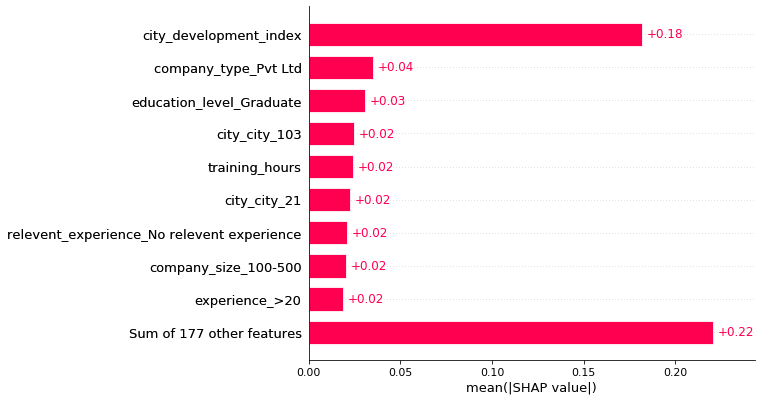

In [41]:
# Features ordered from highest to lowest impact on prediction

shap.plots.bar(shap_values)

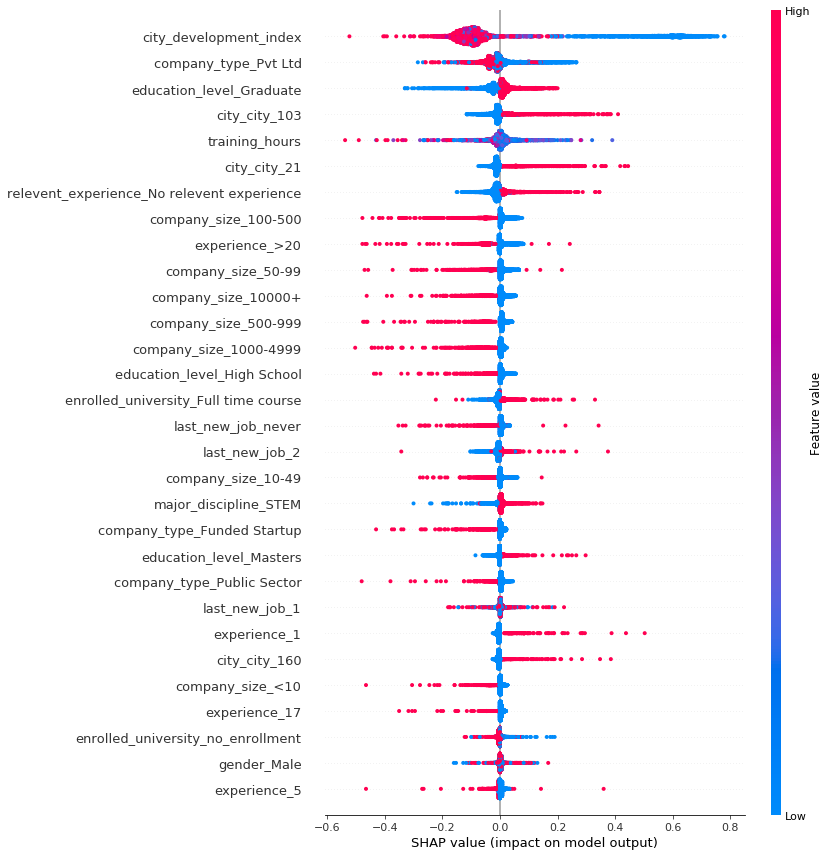

In [42]:
# How do higher/lower values of each feature affect the prediction?

shap.summary_plot(shap_values, plot_size = (12,12), max_display = 30)